/tmp/ipython-input-3010228545.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  17 of 17 completed


Data shape: (3452, 17)


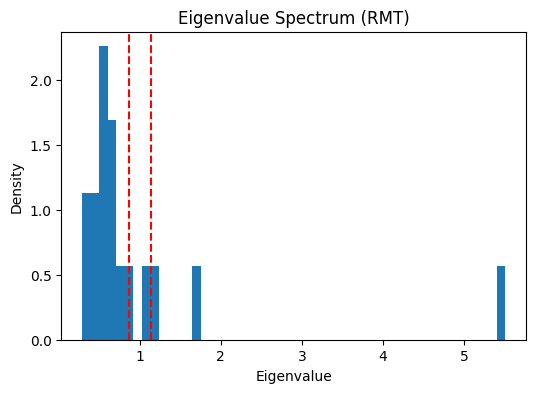

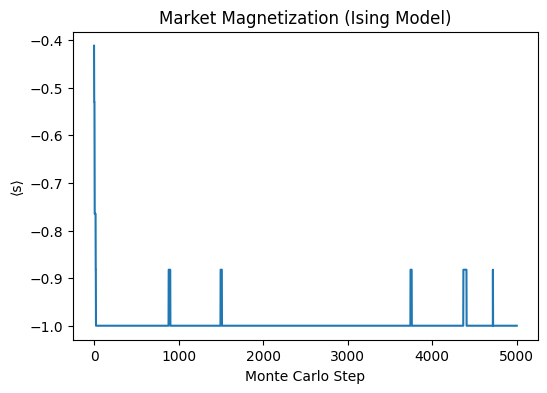

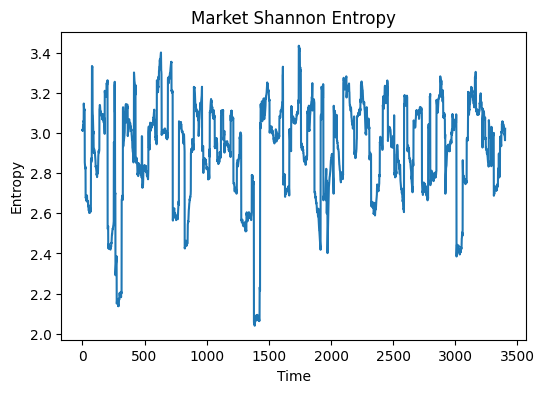

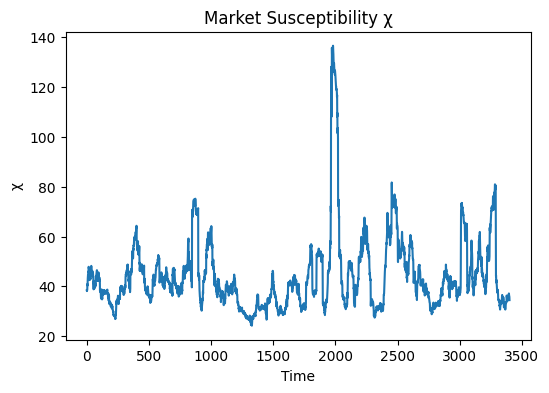

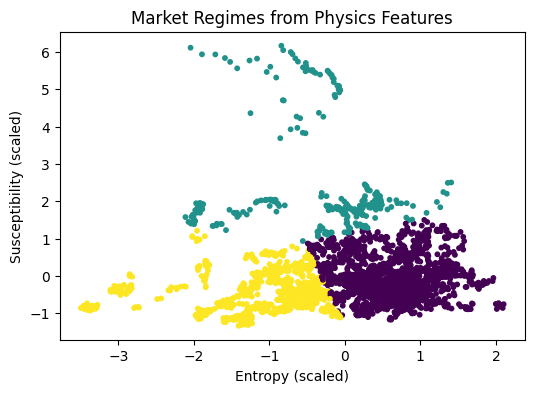

Project completed successfully.
Modules used: RMT | Ising Model | Entropy | Susceptibility | Clustering


In [6]:

!pip install yfinance networkx scikit-learn tqdm scipy


import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.random.seed(42)


tickers = [
    # Banking & Financials (systemic core)
    "HDFCBANK.NS",
    "ICICIBANK.NS",
    "SBIN.NS",
    "AXISBANK.NS",

    # IT & Tech
    "TCS.NS",
    "INFY.NS",
    "WIPRO.NS",

    # Energy & Commodities
    "RELIANCE.NS",
    "ONGC.NS",

    # FMCG / Consumption (defensive)
    "HINDUNILVR.NS",
    "ITC.NS",
    "NESTLEIND.NS",

    # Industrials & Infrastructure
    # "LARSEN.NS", # Removed due to download issues
    "ULTRACEMCO.NS",

    # Metals
    "TATASTEEL.NS",

    # Pharma / Healthcare
    "SUNPHARMA.NS",

    # Auto
    "MARUTI.NS",

    # Power / Utilities
    "NTPC.NS"
]


start_date = "2012-01-01"
end_date = "2026-01-01"

prices = yf.download(tickers, start=start_date, end=end_date)["Close"]
returns = np.log(prices / prices.shift(1)).dropna()

print("Data shape:", returns.shape)

# ---------- RANDOM MATRIX THEORY FILTER ----------
def rmt_filter(returns):
    T, N = returns.shape
    Q = T / N

    C = np.corrcoef(returns.T)

    eigenvalues, eigenvectors = np.linalg.eigh(C)

    lambda_plus = (1 + np.sqrt(1/Q))**2
    lambda_minus = (1 - np.sqrt(1/Q))**2

    filtered_eigenvalues = [
        ev if (ev > lambda_plus or ev < lambda_minus) else 0
        for ev in eigenvalues
    ]

    C_filtered = eigenvectors @ np.diag(filtered_eigenvalues) @ eigenvectors.T
    return C, C_filtered, eigenvalues, lambda_plus, lambda_minus

C, C_filtered, eigvals, l_plus, l_minus = rmt_filter(returns)

plt.figure(figsize=(6,4))
plt.hist(eigvals, bins=50, density=True)
plt.axvline(l_plus, color='r', linestyle='--')
plt.axvline(l_minus, color='r', linestyle='--')
plt.title("Eigenvalue Spectrum (RMT)")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()

# ---------- ISING MARKET MODEL ----------
def returns_to_spins(returns):
    spins = np.sign(returns)
    spins[spins == 0] = 1
    return spins

spins = returns_to_spins(returns)

def ising_energy(spin_config, J):
    return -0.5 * np.sum(J * np.outer(spin_config, spin_config))

def metropolis_step(spins, J, beta=1.0):
    N = len(spins)
    i = np.random.randint(N)

    flipped = spins.copy()
    flipped[i] *= -1

    dE = ising_energy(flipped, J) - ising_energy(spins, J)

    if dE < 0 or np.random.rand() < np.exp(-beta * dE):
        spins = flipped
    return spins

def simulate_ising(J, steps=5000, beta=1.0):
    spins = np.random.choice([-1,1], size=J.shape[0])
    magnetization = []

    for _ in range(steps):
        spins = metropolis_step(spins, J, beta)
        magnetization.append(np.mean(spins))

    return np.array(magnetization)

J = C_filtered
mag = simulate_ising(J)

plt.figure(figsize=(6,4))
plt.plot(mag)
plt.title("Market Magnetization (Ising Model)")
plt.xlabel("Monte Carlo Step")
plt.ylabel("⟨s⟩")
plt.show()

# ---------- INFORMATION THEORY ----------
def rolling_entropy(returns, window=50):
    entropies = []
    for i in range(window, len(returns)):
        hist, _ = np.histogram(
            returns.iloc[i-window:i].values.flatten(),
            bins=50,
            density=True
        )
        entropies.append(entropy(hist + 1e-12))
    return np.array(entropies)

ent = rolling_entropy(returns)

plt.figure(figsize=(6,4))
plt.plot(ent)
plt.title("Market Shannon Entropy")
plt.xlabel("Time")
plt.ylabel("Entropy")
plt.show()

# ---------- SYSTEMIC RISK (SUSCEPTIBILITY) ----------
def susceptibility(returns, window=50):
    chi = []
    for i in range(window, len(returns)):
        C = np.corrcoef(returns.iloc[i-window:i].T)
        chi.append(np.sum(C**2))
    return np.array(chi)

chi = susceptibility(returns)

plt.figure(figsize=(6,4))
plt.plot(chi)
plt.title("Market Susceptibility χ")
plt.xlabel("Time")
plt.ylabel("χ")
plt.show()

# ---------- PHYSICS-BASED REGIME CLASSIFICATION ----------
min_len = min(len(ent), len(chi))
features = np.column_stack([
    ent[:min_len],
    chi[:min_len]
])

features = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(features)

plt.figure(figsize=(6,4))
plt.scatter(features[:,0], features[:,1], c=labels, cmap="viridis", s=10)
plt.xlabel("Entropy (scaled)")
plt.ylabel("Susceptibility (scaled)")
plt.title("Market Regimes from Physics Features")
plt.show()

# ---------- SUMMARY OUTPUT ----------
print("Project completed successfully.")
print("Modules used: RMT | Ising Model | Entropy | Susceptibility | Clustering")